17:56:43 - cmdstanpy - INFO - Chain [1] start processing
17:56:43 - cmdstanpy - INFO - Chain [1] done processing


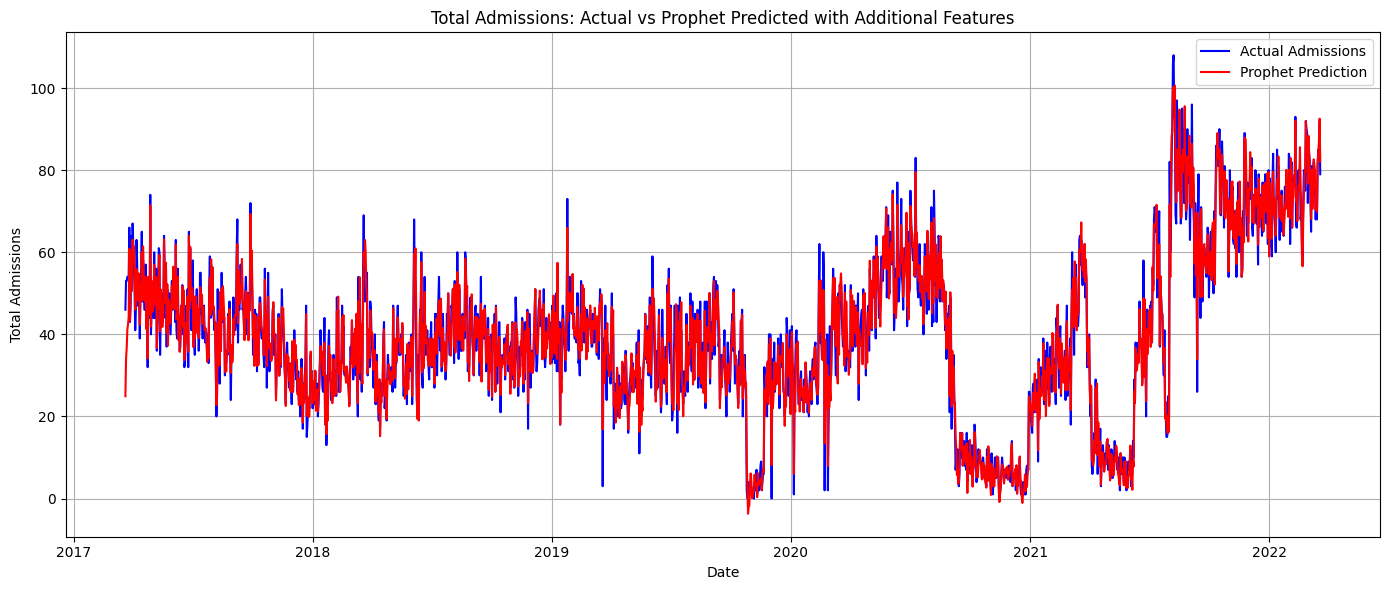

Mean Squared Error (MSE) with Prophet + Additional Features: 11.62


In [67]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
 
# Load data
hospital_data = pd.read_csv('feature_engineering_data.csv')
hospital_data['ResidentDate'] = pd.to_datetime(hospital_data['ResidentDate'])
 
# Prepare data for Prophet
prophet_data = hospital_data.groupby('ResidentDate').agg({
    'Total_Admissions': 'sum',
    'temperature_max': 'mean',
    'temperature_min': 'mean',
    'temp_range': 'mean',
    'precipitation': 'mean',
    'is_rain': 'max',
    'is_weekend': 'max',
    'season': 'first',
    'Festival': 'max',
    'pandemic_flag': 'max',
    'disaster_flag': 'max',
    'Total_Admissions_Lag1': 'mean',
    'Total_Admissions_Lag7': 'mean',
    'Total_Admissions_MA7': 'mean',
    'Total_Admissions_MA14': 'mean',
    'Total_Admissions_EMA': 'mean',
    'Total_Admissions_Rolling_Std': 'mean',
    'Total_Admissions_Rolling_Min': 'mean',
    'Total_Admissions_Rolling_Max': 'mean'
}).reset_index()
 
prophet_data.rename(columns={'ResidentDate': 'ds', 'Total_Admissions': 'y'}, inplace=True)
 
# Train-test split
split_point = round(len(prophet_data) * 0.7)
train = prophet_data.iloc[:split_point]
test = prophet_data.iloc[split_point:]
 
# Initialize Prophet with external regressors
model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    changepoint_prior_scale=0.01
)
 
# Add external regressors
regressors = [
    'temperature_max', 'temperature_min', 'temp_range', 'precipitation',
    'is_rain', 'is_weekend', 'season', 'Festival', 'pandemic_flag', 'disaster_flag',
    'Total_Admissions_Lag1', 'Total_Admissions_Lag7', 'Total_Admissions_MA7',
    'Total_Admissions_MA14', 'Total_Admissions_EMA', 'Total_Admissions_Rolling_Std',
    'Total_Admissions_Rolling_Min', 'Total_Admissions_Rolling_Max'
]
 
for reg in regressors:
    model.add_regressor(reg)
 
# Fit the model
model.fit(train)
 
# Create future dataframe for prediction
future = prophet_data[['ds'] + regressors]
 
# Forecast
forecast = model.predict(future)
 
# Merge predictions with original data
forecast = forecast[['ds', 'yhat']].set_index('ds')
combined = prophet_data.set_index('ds').join(forecast)
 
# Plot
plt.figure(figsize=(14, 6))
plt.plot(combined.index, combined['y'], label='Actual Admissions', color='blue')
plt.plot(combined.index, combined['yhat'], label='Prophet Prediction', color='red')
plt.xlabel('Date')
plt.ylabel('Total Admissions')
plt.title('Total Admissions: Actual vs Prophet Predicted with Additional Features')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
 
# Evaluate prediction accuracy on test set
forecast = forecast.reindex(test['ds'], fill_value=None)
test_pred = forecast.loc[test['ds'], 'yhat'].dropna()
test_actual = test.set_index('ds').loc[test_pred.index, 'y']
mse = mean_squared_error(test_actual, test_pred)
 
print(f"Mean Squared Error (MSE) with Prophet + Additional Features: {mse:.2f}")

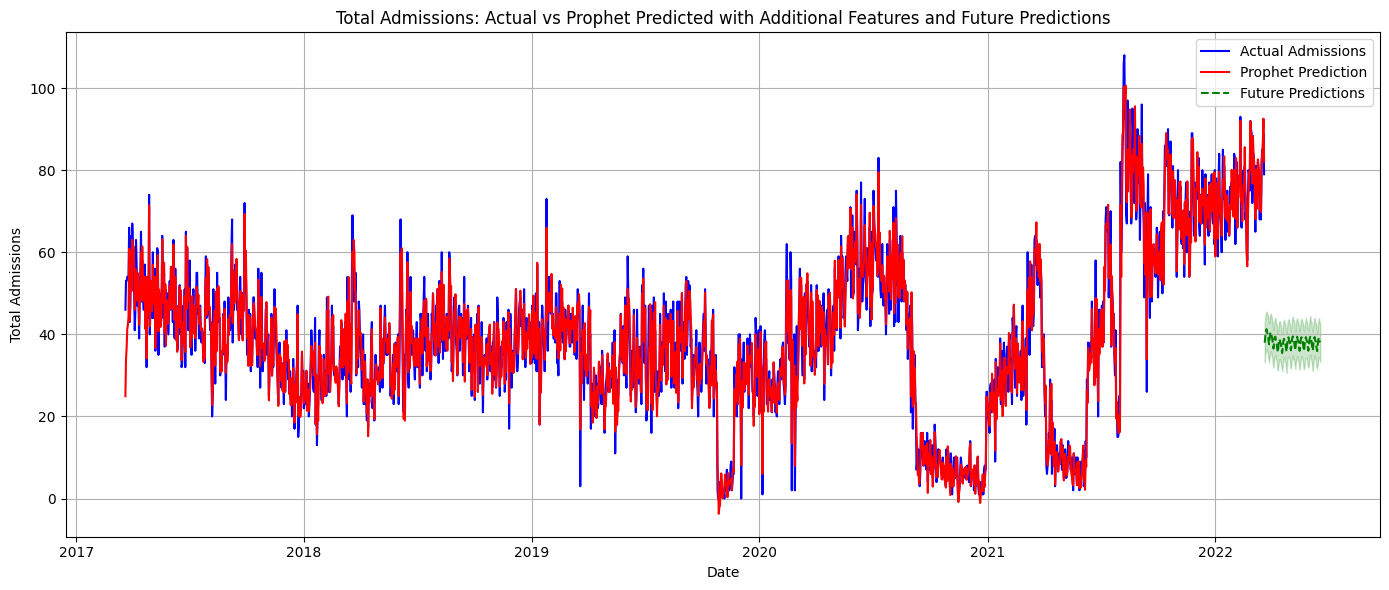

           ds       yhat  yhat_lower  yhat_upper
0  2022-03-21  37.958081   33.205664   42.462280
1  2022-03-22  39.607366   34.956463   44.417906
2  2022-03-23  40.868687   36.203517   45.268485
3  2022-03-24  41.255375   36.423065   45.588313
4  2022-03-25  40.361527   35.825429   44.742475
..        ...        ...         ...         ...
85 2022-06-14  37.536637   32.618712   42.126493
86 2022-06-15  38.789431   34.120464   43.254760
87 2022-06-16  39.189383   34.514856   43.959176
88 2022-06-17  38.330600   34.139200   42.972973
89 2022-06-18  38.069271   33.267228   42.470626

[90 rows x 4 columns]


In [68]:
# Import necessary libraries
import numpy as np

# Define the number of days to predict into the future
future_days = 90  # For example, predicting for the next 3 months

# Create a future dataframe
last_date = prophet_data['ds'].max()
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=future_days)
future = pd.DataFrame({'ds': future_dates})

# Add the external regressors to the future dataframe
# Here we will use the mean of the training set for each regressor
mean_values = train[regressors].mean()
for reg in regressors:
    future[reg] = mean_values[reg]

# Forecast for the future dates
future_forecast = model.predict(future)

# Extract the relevant columns
future_forecast = future_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

# Plot the future predictions along with the historical data
plt.figure(figsize=(14, 6))
plt.plot(combined.index, combined['y'], label='Actual Admissions', color='blue')
plt.plot(combined.index, combined['yhat'], label='Prophet Prediction', color='red')
plt.plot(future_forecast['ds'], future_forecast['yhat'], label='Future Predictions', color='green', linestyle='--')
plt.fill_between(future_forecast['ds'], future_forecast['yhat_lower'], future_forecast['yhat_upper'], color='green', alpha=0.2)
plt.xlabel('Date')
plt.ylabel('Total Admissions')
plt.title('Total Admissions: Actual vs Prophet Predicted with Additional Features and Future Predictions')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Display the future predictions
print(future_forecast)

ADF Statistic: -2.7862955756763235
p-value: 0.060258169716754635
The time series is not stationary
ADF Statistic: -15.750882113052876
p-value: 1.2237472923441344e-28
The time series is stationary


c:\Users\TottaraDhanush\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\TottaraDhanush\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\TottaraDhanush\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\TottaraDhanush\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: Val

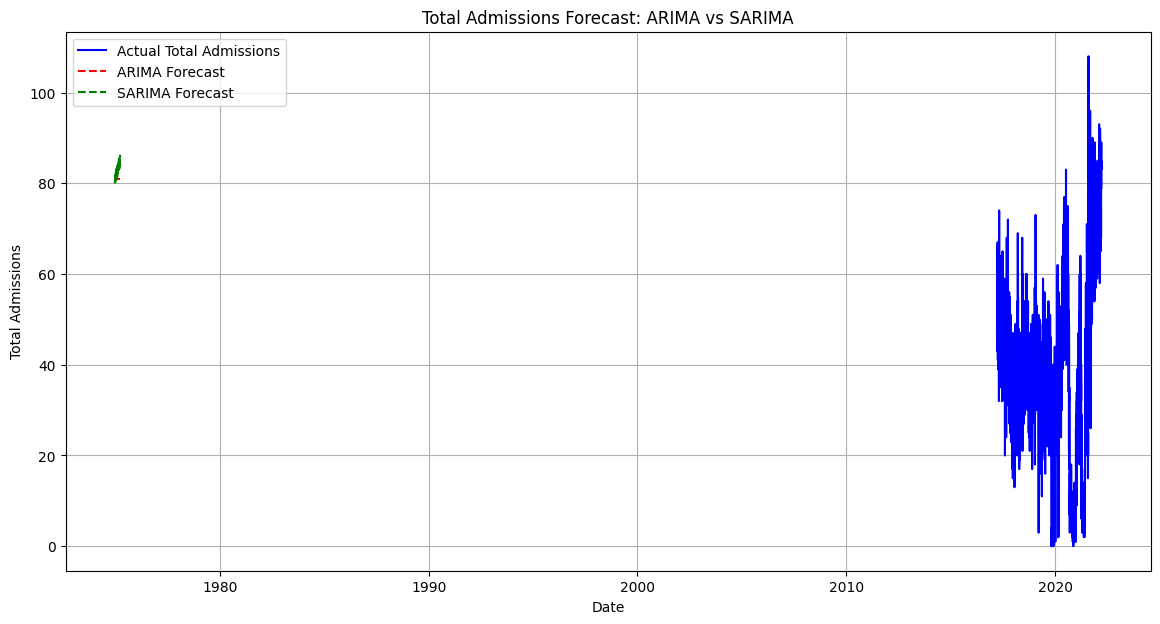

ARIMA Forecast:
1819    80.709369
1820    80.920677
1821    80.946798
1822    80.950027
1823    80.950427
          ...    
1904    80.950483
1905    80.950483
1906    80.950483
1907    80.950483
1908    80.950483
Name: predicted_mean, Length: 90, dtype: float64

SARIMA Forecast:
1819    80.259564
1820    80.954809
1821    80.739052
1822    79.789829
1823    82.411448
          ...    
1904    85.027896
1905    84.740982
1906    83.741144
1907    86.097340
1908    85.736523
Name: predicted_mean, Length: 90, dtype: float64


In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

# Load the data
hospital_data = pd.read_csv('feature_engineering_data.csv')
hospital_data['ResidentDate'] = pd.to_datetime(hospital_data['ResidentDate'])
hospital_data.set_index('ResidentDate', inplace=True)

# Select the target variable
data = hospital_data['Total_Admissions']

# Check for stationarity
def test_stationarity(timeseries):
    result = adfuller(timeseries)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    if result[1] <= 0.05:
        print("The time series is stationary")
    else:
        print("The time series is not stationary")

test_stationarity(data)

# If the series is not stationary, difference the data
data_diff = data.diff().dropna()
test_stationarity(data_diff)

# Fit ARIMA model
p, d, q = 1, 1, 1  # Adjust these parameters based on ACF and PACF plots
arima_model = ARIMA(data, order=(p, d, q))
arima_model_fit = arima_model.fit()

# Forecasting with ARIMA
arima_forecast = arima_model_fit.forecast(steps=90)  # Forecast for the next 90 days

# Fit SARIMA model
P, D, Q, m = 1, 1, 1, 12  # Adjust these parameters based on seasonal patterns
sarima_model = SARIMAX(data, order=(p, d, q), seasonal_order=(P, D, Q, m))
sarima_model_fit = sarima_model.fit()

# Forecasting with SARIMA
sarima_forecast = sarima_model_fit.forecast(steps=90)  # Forecast for the next 90 days

# Plotting the results
plt.figure(figsize=(14, 7))
plt.plot(data, label='Actual Total Admissions', color='blue')
plt.plot(arima_forecast.index, arima_forecast, label='ARIMA Forecast', color='red', linestyle='--')
plt.plot(sarima_forecast.index, sarima_forecast, label='SARIMA Forecast', color='green', linestyle='--')
plt.title('Total Admissions Forecast: ARIMA vs SARIMA')
plt.xlabel('Date')
plt.ylabel('Total Admissions')
plt.legend()
plt.grid()
plt.show()

# Print the forecasts
print("ARIMA Forecast:")
print(arima_forecast)
print("\nSARIMA Forecast:")
print(sarima_forecast)

ADF Statistic: -2.7862955756763235
p-value: 0.060258169716754635
The time series is not stationary
ADF Statistic: -15.750882113052876
p-value: 1.2237472923441344e-28
The time series is stationary


c:\Users\TottaraDhanush\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\TottaraDhanush\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\TottaraDhanush\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\TottaraDhanush\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: Val

Actual Total Admissions (last 3 entries):
ResidentDate
2022-03-18    83
2022-03-19    89
2022-03-20    79
Name: Total_Admissions, dtype: int64

ARIMA Forecast for the next 90 days:
1819    80.709369
1820    80.920677
1821    80.946798
1822    80.950027
1823    80.950427
          ...    
1904    80.950483
1905    80.950483
1906    80.950483
1907    80.950483
1908    80.950483
Name: predicted_mean, Length: 90, dtype: float64

SARIMA Forecast for the next 90 days:
1819    80.259564
1820    80.954809
1821    80.739052
1822    79.789829
1823    82.411448
          ...    
1904    85.027896
1905    84.740982
1906    83.741144
1907    86.097340
1908    85.736523
Name: predicted_mean, Length: 90, dtype: float64


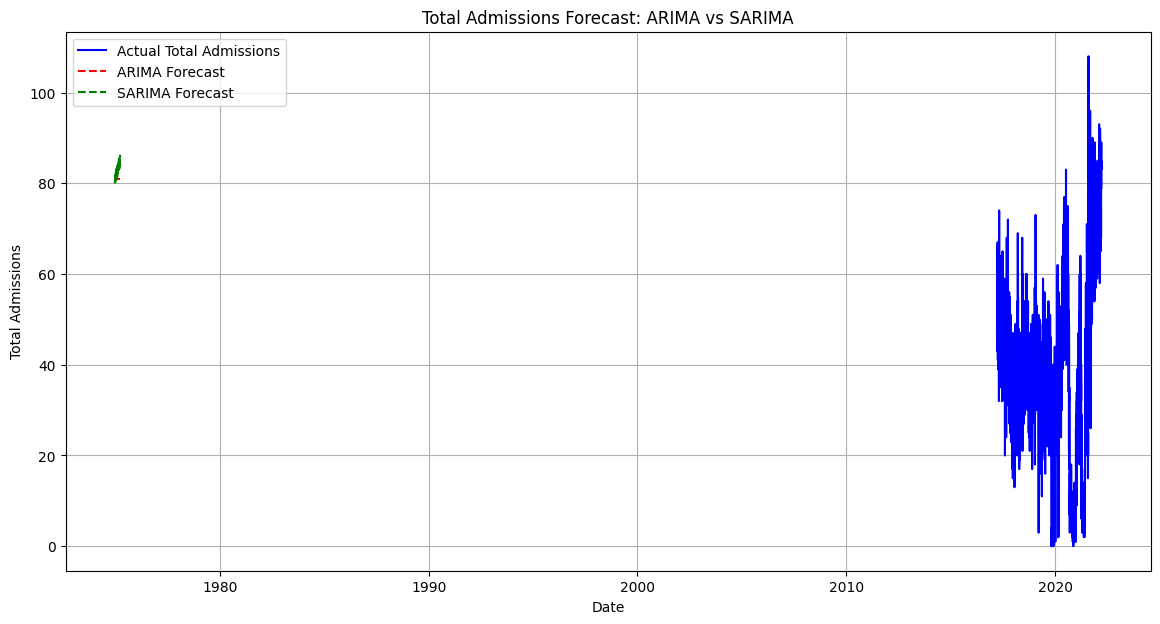

In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

# Load the dataset
hospital_data = pd.read_csv('feature_engineering_data.csv')
hospital_data['ResidentDate'] = pd.to_datetime(hospital_data['ResidentDate'])
hospital_data.set_index('ResidentDate', inplace=True)

# Select the target variable
total_admissions = hospital_data['Total_Admissions']

# Check for stationarity
def test_stationarity(timeseries):
    result = adfuller(timeseries)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    if result[1] <= 0.05:
        print("The time series is stationary")
    else:
        print("The time series is not stationary")

test_stationarity(total_admissions)

# If the series is not stationary, difference the data
total_admissions_diff = total_admissions.diff().dropna()
test_stationarity(total_admissions_diff)

# Fit ARIMA model
p, d, q = 1, 1, 1  # Adjust these parameters based on ACF and PACF plots
arima_model = ARIMA(total_admissions, order=(p, d, q))
arima_model_fit = arima_model.fit()

# Fit SARIMA model
P, D, Q, m = 1, 1, 1, 12  # Adjust these parameters based on seasonal patterns
sarima_model = SARIMAX(total_admissions, order=(p, d, q), seasonal_order=(P, D, Q, m))
sarima_model_fit = sarima_model.fit()

# Forecasting with ARIMA
arima_forecast = arima_model_fit.forecast(steps=90)  # Forecast for the next 90 days

# Forecasting with SARIMA
sarima_forecast = sarima_model_fit.forecast(steps=90)  # Forecast for the next 90 days

# Print actual admissions
print("Actual Total Admissions (last 3 entries):")
print(total_admissions.tail(3))  # Display the last 3 actual admissions

# Print forecasts
print("\nARIMA Forecast for the next 90 days:")
print(arima_forecast)

print("\nSARIMA Forecast for the next 90 days:")
print(sarima_forecast)

# Plotting the results
plt.figure(figsize=(14, 7))
plt.plot(total_admissions, label='Actual Total Admissions', color='blue')
plt.plot(arima_forecast.index, arima_forecast, label='ARIMA Forecast', color='red', linestyle='--')
plt.plot(sarima_forecast.index, sarima_forecast, label='SARIMA Forecast', color='green', linestyle='--')
plt.title('Total Admissions Forecast: ARIMA vs SARIMA')
plt.xlabel('Date')
plt.ylabel('Total Admissions')
plt.legend()
plt.grid()
plt.show()

Number of missing values: 0
Number of infinite values: 0

After cleaning:
ADF Statistic: -2.7862955756763235
p-value: 0.060258169716754635
The time series is not stationary

Differenced series:
ADF Statistic: -15.750882113052876
p-value: 1.2237472923441344e-28
The time series is stationary


c:\Users\TottaraDhanush\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\TottaraDhanush\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\TottaraDhanush\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\TottaraDhanush\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: Val


ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:       Total_Admissions   No. Observations:                 1819
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -6535.299
Date:                Tue, 15 Apr 2025   AIC                          13076.597
Time:                        18:13:56   BIC                          13093.114
Sample:                             0   HQIC                         13082.691
                               - 1819                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1236      0.031      3.928      0.000       0.062       0.185
ma.L1         -0.7405      0.018    -41.256      0.000      -0.776      -0.705
sigma2        77.5773      1.7

c:\Users\TottaraDhanush\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\TottaraDhanush\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\TottaraDhanush\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


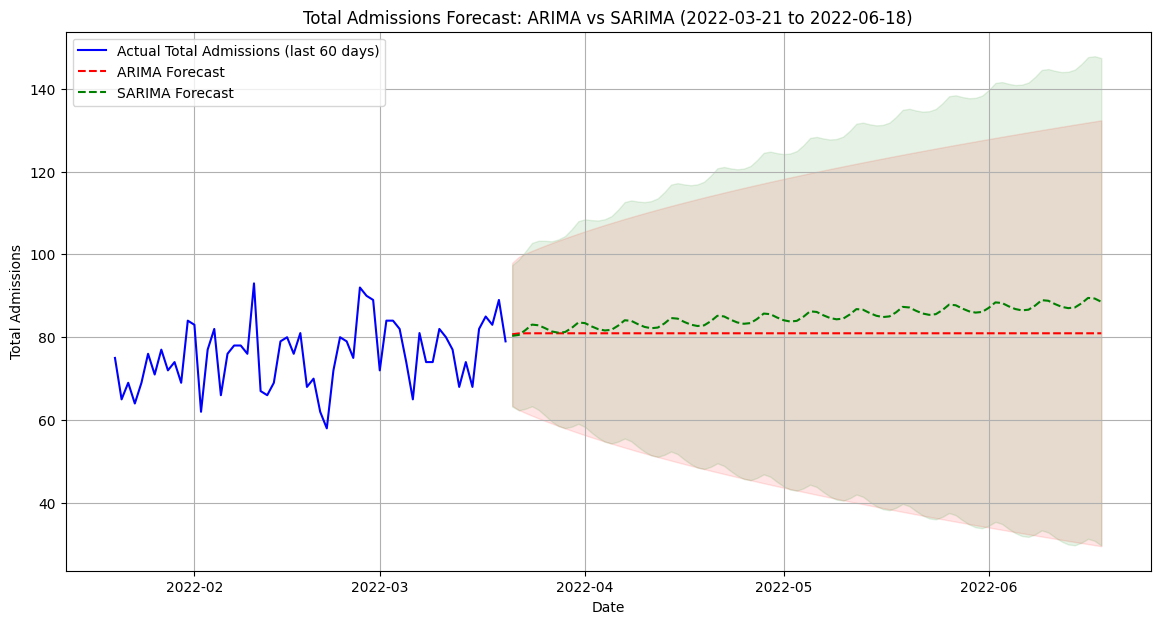

In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

# Load the dataset
hospital_data = pd.read_csv('feature_engineering_data.csv')
hospital_data['ResidentDate'] = pd.to_datetime(hospital_data['ResidentDate'])
hospital_data.set_index('ResidentDate', inplace=True)

# Select the target variable and handle missing/infinite values
total_admissions = hospital_data['Total_Admissions']

# 1. Check for infinite values and replace with NaN
total_admissions.replace([np.inf, -np.inf], np.nan, inplace=True)

# 2. Check for missing values
print(f"Number of missing values: {total_admissions.isna().sum()}")
print(f"Number of infinite values: {np.isinf(total_admissions).sum()}")

# 3. Handle missing values (interpolate or fill)
# Option 1: Linear interpolation
total_admissions = total_admissions.interpolate(method='linear')

# Option 2: Forward fill (use previous value)
# total_admissions = total_admissions.ffill()

# Option 3: Backward fill (use next value)
# total_admissions = total_admissions.bfill()

# If there are still missing values at the start/end, drop them
total_admissions = total_admissions.dropna()

# Check for stationarity
def test_stationarity(timeseries):
    # Ensure no NaN/inf values remain
    if timeseries.isna().any() or np.isinf(timeseries).any():
        raise ValueError("Time series contains NaN or inf values")
    
    result = adfuller(timeseries)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    if result[1] <= 0.05:
        print("The time series is stationary")
    else:
        print("The time series is not stationary")

print("\nAfter cleaning:")
test_stationarity(total_admissions)

# Difference the data if not stationary
total_admissions_diff = total_admissions.diff().dropna()
print("\nDifferenced series:")
test_stationarity(total_admissions_diff)

# Fit ARIMA model
try:
    p, d, q = 1, 1, 1
    arima_model = ARIMA(total_admissions, order=(p, d, q))
    arima_model_fit = arima_model.fit()
    print("\nARIMA Model Summary:")
    print(arima_model_fit.summary())
except Exception as e:
    print(f"\nError fitting ARIMA model: {e}")
    arima_model_fit = None

# Fit SARIMA model
try:
    P, D, Q, m = 1, 1, 1, 7  # Weekly seasonality
    sarima_model = SARIMAX(total_admissions, order=(p, d, q), seasonal_order=(P, D, Q, m))
    sarima_model_fit = sarima_model.fit()
    print("\nSARIMA Model Summary:")
    print(sarima_model_fit.summary())
except Exception as e:
    print(f"\nError fitting SARIMA model: {e}")
    sarima_model_fit = None

# Create date range for forecasting
last_date = total_admissions.index[-1]
forecast_start = last_date + pd.Timedelta(days=1)
forecast_end = forecast_start + pd.Timedelta(days=89)  # 90 days total
forecast_dates = pd.date_range(start=forecast_start, end=forecast_end, freq='D')

# Forecasting with ARIMA
if arima_model_fit is not None:
    arima_forecast = arima_model_fit.get_forecast(steps=90)
    arima_forecast_mean = arima_forecast.predicted_mean
    arima_forecast_mean.index = forecast_dates
    arima_conf_int = arima_forecast.conf_int()
else:
    arima_forecast_mean = pd.Series(np.nan, index=forecast_dates)
    arima_conf_int = None

# Forecasting with SARIMA
if sarima_model_fit is not None:
    sarima_forecast = sarima_model_fit.get_forecast(steps=90)
    sarima_forecast_mean = sarima_forecast.predicted_mean
    sarima_forecast_mean.index = forecast_dates
    sarima_conf_int = sarima_forecast.conf_int()
else:
    sarima_forecast_mean = pd.Series(np.nan, index=forecast_dates)
    sarima_conf_int = None

# Print actual admissions
print("\nActual Total Admissions (last 5 entries):")
print(total_admissions.tail(5))

# Print forecasts if available
if arima_model_fit is not None:
    print("\nARIMA Forecast for the next 90 days (2022-03-21 to 2022-06-18):")
    print(arima_forecast_mean.head(10))
else:
    print("\nARIMA Forecast not available")

if sarima_model_fit is not None:
    print("\nSARIMA Forecast for the next 90 days (2022-03-21 to 2022-06-18):")
    print(sarima_forecast_mean.head(10))
else:
    print("\nSARIMA Forecast not available")

# Plotting the results
plt.figure(figsize=(14, 7))
plt.plot(total_admissions[-60:], label='Actual Total Admissions (last 60 days)', color='blue')

if arima_model_fit is not None:
    plt.plot(arima_forecast_mean, label='ARIMA Forecast', color='red', linestyle='--')
    if arima_conf_int is not None:
        plt.fill_between(forecast_dates, 
                        arima_conf_int.iloc[:, 0], 
                        arima_conf_int.iloc[:, 1], 
                        color='red', alpha=0.1)

if sarima_model_fit is not None:
    plt.plot(sarima_forecast_mean, label='SARIMA Forecast', color='green', linestyle='--')
    if sarima_conf_int is not None:
        plt.fill_between(forecast_dates, 
                        sarima_conf_int.iloc[:, 0], 
                        sarima_conf_int.iloc[:, 1], 
                        color='green', alpha=0.1)

plt.title('Total Admissions Forecast: ARIMA vs SARIMA (2022-03-21 to 2022-06-18)')
plt.xlabel('Date')
plt.ylabel('Total Admissions')
plt.legend()
plt.grid()
plt.show()